In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import os
import matplotlib.pyplot as plt
import random
import scipy as sp
 
from math import sqrt, exp
from scipy.stats import norm
from pylab import plot, show, grid, xlabel, ylabel

In [2]:
os.chdir('C:\\Users\\Ramona\\OneDrive\\Dokumente\\Studium\\Master Statistik\\Quantitative Methods of Financial Markets\\DEDA\\notebooks')

## Example with real data

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
btc_usd = pd.read_csv("data\\BTC-USD.csv")
housing = pd.read_excel("data\\housing.xlsx")

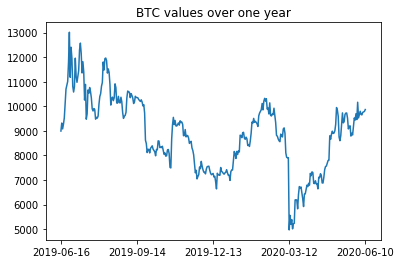

In [4]:
#btc_usd['Close'].plot()
plt.plot(btc_usd['Date'], btc_usd['Close'])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(90))
plt.title('BTC values over one year')
plt.savefig('plots\\year_btc.png', transparent=True)
show()

In [5]:
housing.loc[housing['TIME']=='2019-Q1']

,TIME,GER
56,2019-Q1,124.6


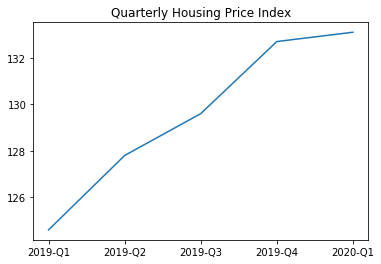

In [6]:
plt.plot(housing['TIME'][56:], housing['GER'][56:])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title('Quarterly Housing Price Index')
#plt.savefig('plots\\housing.png', transparent=True)
show()

In [7]:
btc_usd.loc[btc_usd['Date']=='2020-03-01']

,Date,Open,High,Low,Close,Adj Close,Volume
259,2020-03-01,8599.758789,8726.796875,8471.212891,8562.454102,8562.454102,35349164300


In [8]:
# create subset, here for month of may
subset = btc_usd[256:289]
subset.index = range(0,len(subset))
subset.index.name = 'Days'
subset['LTV']=''

In [9]:
# borrowed amount in USD
B0 = 10000

# pre-agreed initial LTV
ltv0 = 0.6
# pre-agreed liquidation threshold
K = 0.9

# danger zone
# D = 0.8

# BTC needed
CS_btc = B0/(ltv0*subset['Close'][0])

# in USD
CS_usd = CS_btc*subset['Close'][0]

print(CS_btc, CS_usd)

1.8972824614769892 16666.666666666668


In [10]:
subset['LTV'][0] = ltv0
for i in range(1,len(subset)):
    subset['LTV'][i] = B0/(CS_btc*subset['Close'][i])

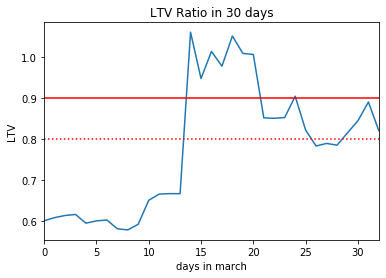

In [11]:
subset['LTV'].plot()
xlabel('days in march')
ylabel('LTV')
plt.title('LTV Ratio in 30 days')
plt.axhline(y=K, color='r', linestyle='-')
plt.axhline(y=0.8, color='r', linestyle='dotted')
#plt.savefig('plots\\case_study.png', transparent=True)
show()

In [12]:
np.argwhere(subset['LTV']>=0.8)[0]

C:\Users\Ramona\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


array([14], dtype=int64)

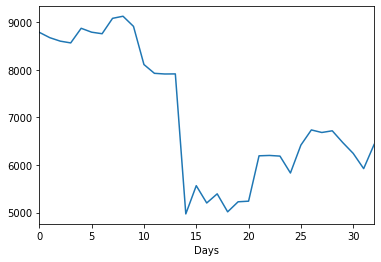

In [13]:
subset['Close'].plot()

## Simulation of BTC Prices and LTVs

In [14]:
def btc_sim(s0, ltv0, n, dt, sigma, mu, out_btc=None, out_ltv=None):
    s0 = np.asarray(s0)
    ltv0 = np.asarray(ltv0)
    
    # For each element of s0, generate a sample of n numbers from a
    # standard normal distribution.
    z = norm.rvs(size=s0.shape + (n,), loc=0.0, scale=1.0)
    
    if out_btc is None:
        out_btc = np.empty(z.shape)
    
    if out_ltv is None:
        out_ltv = np.empty(z.shape)
    
    incr_s = np.exp(sigma*np.sqrt(dt)*z + (mu - (sigma**2)/2)*dt)
    incr_ltv = np.exp(-sigma*np.sqrt(dt)*z + (-mu + sigma**2-(sigma**2)/2)*dt)
    
    np.cumprod(incr_s, axis=-1, out=out_btc)
    np.cumprod(incr_ltv, axis=-1, out=out_ltv)
    
    out_btc *= np.expand_dims(s0, axis=-1)
    out_ltv *= np.expand_dims(ltv0, axis=-1)

    return out_btc, out_ltv

In [15]:
T = 12.0
N = 365
#dt = T/N  
dt = 1/N

#t = np.linspace(0.0, N*dt, N+1)
t = np.linspace(0.0, T, N+1)

# number of realizations
m = 10000

# drift rate
mu = 0.088
# volatility
sigma = 0.65

#bitcoin value on 07/06/2020 in USD
#S0 = 9495.70
#bitcoin value on 12/06/2020
S0 = 9425.92
LTV0 = 0.6
#CR0 = 1.75

K = 0.9

S = np.empty((m,N+1))
S[:,0] = S0

LTV = np.empty((m,N+1))
LTV[:,0] = LTV0

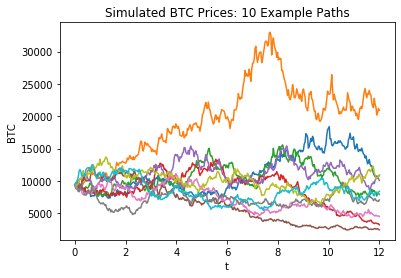

In [16]:
# simulation with positive drift rate
#np.random.seed(2020)
np.random.seed(202006)
btc_sim(S[:,0], LTV[:,0], N, dt, sigma, mu,
        out_btc=S[:,1:], out_ltv=LTV[:,1:])

for k in range(10):    
    plot(t, S[k])

#plot(t, S[0])

xlabel('t')
ylabel('BTC')
plt.title('Simulated BTC Prices: 10 Example Paths')
#leg = plt.legend()
#grid(True)
#plt.savefig('plots\\sim_btc.png', transparent=True)
show()

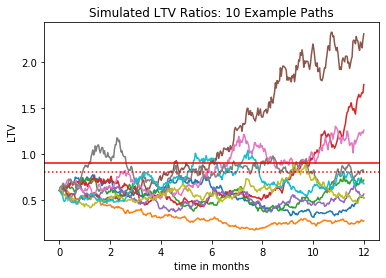

In [17]:
for k in range(10):    
    plot(t, LTV[k])

#plot(t, LTV[40])

xlabel('time in months')
ylabel('LTV')
plt.title('Simulated LTV Ratios: 10 Example Paths')
plt.axhline(y=K, color='r', linestyle='-')
plt.axhline(y=0.8, color='r', linestyle='dotted')
plt.savefig('plots\\sim_ltv.png', transparent=True)
#leg = plt.legend()
#grid(True)
show()

In [18]:
x=np.argwhere(LTV>=0.8)
#np.shape(x)
x[np.argwhere(x[:,1:]<=20)]

array([[[  48,   19],
        [   3,  282]],

       [[  48,   20],
        [   3,  282]],

       [[  59,    9],
        [   3,  282]],

       ...,

       [[9999,   18],
        [   3,  282]],

       [[9999,   19],
        [   3,  282]],

       [[9999,   20],
        [   3,  282]]], dtype=int64)

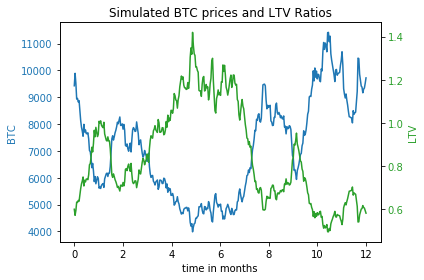

In [19]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time in months')
ax1.set_ylabel('BTC', color=color)
ax1.plot(t, S[48], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:green'
ax2.set_ylabel('LTV', color=color)  
ax2.plot(t, LTV[48], color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.axhline(y=1.5, color='r', linestyle='-')

plt.title('Simulated BTC prices and LTV Ratios')
fig.tight_layout() 
#plt.savefig('plots\\sim_2.png', transparent=True)
plt.show()

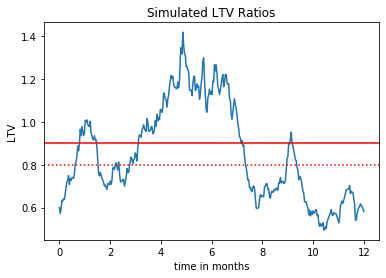

In [20]:
plot(t, LTV[48])

xlabel('time in months')
ylabel('LTV')
plt.title('Simulated LTV Ratios')
plt.axhline(y=K, color='r', linestyle='-')
plt.axhline(y=0.8, color='r', linestyle='dotted')
plt.savefig('plots\\sim_ltv.png', transparent=True)
#leg = plt.legend()
#grid(True)
show()

## Stochastic Volatility Jumps

In [21]:
# SVCJ parameters
#mu      = 0.042
#r       = mu
mu_y    = -0.0492
sigma_y = 2.061
l       = 0.0515
alpha   = 0.0102
beta    = -0.188
rho     = 0.275
sigma_v = 0.007
rho_j   = -0.210
mu_v    = 0.709
v0      = 0.19**2 
kappa   = 1-beta
theta   = alpha / kappa

In [22]:
np.random.seed(202006)
w      = npr.standard_normal([m,N])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([m,N])
z_v    = npr.exponential(mu_v, [m,N])
z_y    = npr.standard_normal([m,N]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[m,N])
s      = np.zeros([m,N+1])
v      = np.zeros([m,N+1])

In [23]:
#s0     = 6500
#k      = 5600
#s[:,0] = s0 # initial CRIX level, p. 20

S_SVCJ = np.empty((m,N+1))
S_SVCJ[:,0] = S0

LTV_SVCJ = np.empty((m,N+1))
LTV_SVCJ[:,0] = LTV0

v = np.empty((m,N))
v[:,0]=v0
for i in range(1,N):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]


In [24]:
def btc_SVCJ(s0, ltv0, v, n, dt, sigma, mu, out_btc=None, out_ltv=None):
    s0 = np.asarray(s0)
    ltv0 = np.asarray(ltv0)
    
    # For each element of s0, generate a sample of n numbers from a
    # standard normal distribution.
    z = norm.rvs(size=s0.shape + (n,), loc=0.0, scale=1.0)
    
    if out_btc is None:
        out_btc = np.empty(z.shape)
    
    if out_ltv is None:
        out_ltv = np.empty(z.shape)
    
    incr_s = np.exp(v*np.sqrt(dt)*z + (mu - (v**2)/2)*dt)
    incr_ltv = np.exp(-v*np.sqrt(dt)*z + (-mu + v**2-(v**2)/2)*dt)
    
    np.cumprod(incr_s, axis=-1, out=out_btc)
    np.cumprod(incr_ltv, axis=-1, out=out_ltv)
    
    out_btc *= np.expand_dims(s0, axis=-1)
    out_ltv *= np.expand_dims(ltv0, axis=-1)

    return out_btc, out_ltv

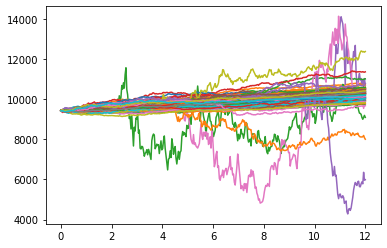

In [25]:
npr.seed(202006)
btc_SVCJ(S_SVCJ[:,0], LTV_SVCJ[:,0], v, N, dt, sigma, mu,
        out_btc=S_SVCJ[:,1:], out_ltv=LTV_SVCJ[:,1:])

for k in range(100):    
    plot(t, S_SVCJ[k])

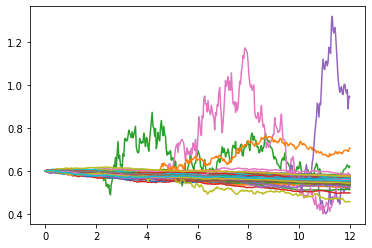

In [26]:
for k in range(100):    
    plot(t, LTV_SVCJ[k])

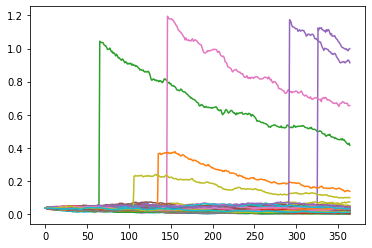

In [27]:
for k in range(100):
    plot(v[k])

In [28]:
y=np.argwhere(LTV_SVCJ>=0.8)
#np.shape(x)
y[np.argwhere(y[:,1:]<=20)]

array([[[9984,   14],
        [  12,  108]],

       [[9984,   17],
        [  12,  108]],

       [[9984,   18],
        [  12,  108]]], dtype=int64)

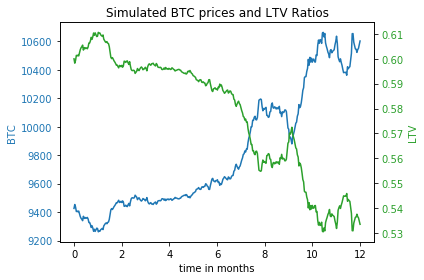

In [30]:
t = np.linspace(0.0, T, N+1)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time in months')
ax1.set_ylabel('BTC', color=color)
ax1.plot(t, S_SVCJ[48], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:green'
ax2.set_ylabel('LTV', color=color)  
ax2.plot(t, LTV_SVCJ[48], color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.axhline(y=1.5, color='r', linestyle='-')

plt.title('Simulated BTC prices and LTV Ratios')
fig.tight_layout() 
#plt.savefig('plots\\sim_2.png', transparent=True)
plt.show()

## Determine Value of Lending Contract

In [31]:
def payoff(S, LTV, B0, l, t, N, r, v=0):
    B = (1+l)*B0             # total repayment
    #CS_usd = CR[v-1,0]*B0   # collateral size
    CS_usd = B0/LTV[v,0]
    CS_btc = CS_usd/S[v,0] # amount of bitcoin needed
    
    # find time points where CR hits K
    tau = np.argwhere(LTV[v] >= K)
    
    if len(tau) == 0:
        F = exp(-r*(N-t)/N)*B
        
    else:
        F = exp(-r*((tau[0]-t)/N))*(CS_btc*S[v,tau[0]])
        
    return F

In [32]:
### contract setup ###
# borrowed amount in USD
B0 = 10000

# pre-agreed interest rate
l = 0.1

# repayment
B = B0*(1+l)

# annual discounting factor
r = 0.01

# threshold for CR
#K = 1.5
K = 0.9

# time point of view (in days)
t = N

In [33]:
# calculate payoff for all contracts
F = np.empty((m))
F_SVCJ = np.empty((m))

for k in range(m):
    F[k]=payoff(S, LTV, B0, l, t, N, r, v=k)
    
for k in range(m):
    F_SVCJ[k]=payoff(S_SVCJ, LTV_SVCJ, B0, l, t, N, r, v=k)

In [34]:
# empirical mean of all contracts
mean = 1/m*sum(F)
mean_svcj = 1/m*sum(F_SVCJ)

# empirical variance
variance = 1/m*(sum(((F-mean)**2)))
sd = sqrt(variance)

print('mean: ', mean, sep="")
print('with jumps:', mean_svcj, sep="")
print('variance: ', variance, sep="")
print('standard deviation: ', sd, sep="")

mean: 10976.623067226259
with jumps:10997.247741082898
variance: 20992.429919523835
standard deviation: 144.887645848512


In [35]:
# therefore, the expected value of the contract is
V = exp(-r)*mean
V_svcj = exp(-r)*mean_svcj

print(V, V_svcj)

10867.403842834641 10887.823297757537


In [36]:
# discounted value of the pre-agreed payback
exp(-r)*B

10890.54817124085

In [37]:
exp(-r)*payoff(S, LTV, B0, l, t, N, r, v=0)

10890.54817124085